# Pre-process Test Set 2

---


Pre-processing the test set in an NLP project is not trivial. We cannot use the same pipeline for the training and test sets. Rather, at each step, we need to be mindful about each of the following steps:

1. N-gram vocabulary
2. Tfidf representation
3. SVD projection
4. Cosine Similarities

__N-gram vocabulary__

While pre-processing the training set we created an N-gram vocabulary, which in essence our feature space. If we apply the same pipeline to the test set we'll be training a completely new set of features - yet we need the same features, in the same order, else our model will not understand what to do and predictions will be all over the place.

In other words, we keep the overlapping vocabulary between traiing and test sets, and discard any new vocabulary. Also, we keep the training vocabulary not present in the test set, just as empty features, so that we can keep the same structure. 

One ramification of all this is that it makes sense why NLP projects benefit from tons of data: the greater the training and test sets, the greater the overlap in tokens.

__Tfidf Representation__

We also created a tfidf representation, where idf stands for the 'inverse document frequency'... *in the training corpus*. The idf of the test corpus is not used. In a way, it's as if the learning process starts during pre-processing and before what's commonly referred to as the modeling phase, by learning the vocabulary and idf of a training corpus.


__SVD projection__

We also need to project each test document $d$ (or rather, the entire matrix of documents $D$) into the same latent semantic space as the training data. For a projected document $\hat{d}$, this is accomplished by using the singular values $\Sigma$ and the $U$ matrix learned during training, and applying the following formula: $\hat{d}=\Sigma^{-1}U^Td$. 

Note how the same formula can be applied for the training data - demonstrated below.

__Cosine Similarities__

In a previous attempt I made a simple yet consequential mistake - I forgot this project is a simulation of reality in which I happened to have the test labels... in essence, we cannot calculate spam similarities using test data because we do not know which SMS messages are spam: *that's what we're trying to predict!*

The fix is below: to add the training svd to the test svd, but only the spam indices, and calculate the square matrix of all similarities based on both, then use the spam columns to calculate mean spam similarities.

### Setup

In [1]:
import os
import sys
import time
import json

import numpy as np
import pandas as pd

from datetime import datetime

np.set_printoptions(threshold=sys.maxsize)

start_ = time.time()
dt_object = datetime.fromtimestamp(start_)
day, T = str(dt_object).split('.')[0].split(' ')
print('Revised on: ' + day)

Revised on: 2021-02-20


### Load Data

In [2]:
import urlextract
from nltk.stem import WordNetLemmatizer

def load_data(data):
    raw_path = os.path.join("data","1_raw")
    filename = ''.join([data, ".csv"])
    out_dfm = pd.read_csv(os.path.join(raw_path, filename))
    out_arr = np.array(out_dfm.iloc[:,0].ravel())
    return out_arr

X_train = load_data("X_train") 
y_train = load_data("y_train") 
X_test = load_data("X_test") 
y_test = load_data("y_test") 

In [3]:
def make_int(y_array):
    y = y_array.copy()
    y[y=='ham'] = 0
    y[y=='spam'] = 1
    y = y.astype('int')
    return y

y_test_int = make_int(y_test)
y_train_int = make_int(y_train)

# load contractions map for custom cleanup
with open("contractions_map.json") as f:
    contractions_map = json.load(f)

###  Define Pipeline

In [4]:
import custom.clean_preprocess as cp
from sklearn.pipeline import Pipeline
from sklearn.feature_extraction.text import TfidfTransformer

pipe = Pipeline([('counter', cp.DocumentToNgramCounterTransformer(n_grams=3)),
                 ('bot', cp.WordCounterToVectorTransformer(vocabulary_size=2000)), # careful
                 ('tfidf', TfidfTransformer(sublinear_tf=True))]) # careful

### Counters & Transformer

I create train and test counters but only need to fit the transformer on the training corpus to get the same 2,000 features in both data sets:

In [5]:
# counters
X_train_counter = pipe['counter'].fit_transform(X_train) 
X_test_counter = pipe['counter'].fit_transform(X_test) 

X_train_transformer = pipe['bot'].fit(X_train_counter) # only on the training counter

Here are the first 11 words in the vocabulary:

In [6]:
first_11_vocab = [w for (ct, w) in enumerate(X_train_transformer.vocabulary_) if ct < 11]
print(first_11_vocab)

['NUM', 'i', 'you', 'u', 'me', 'not', 'my', 'your', 'am', 'have', 'call']


### Bag-of-upto-Trigrams

In [7]:
# BoTs
X_train_bot = X_train_transformer.transform(X_train_counter)
X_test_bot = X_train_transformer.transform(X_test_counter) # same transformer

In [8]:
# sanity checks
X_train_bot, X_test_bot

(<3900x2001 sparse matrix of type '<class 'numpy.intc'>'
 	with 59102 stored elements in Compressed Sparse Row format>,
 <1672x2001 sparse matrix of type '<class 'numpy.intc'>'
 	with 24657 stored elements in Compressed Sparse Row format>)

Both Bag of Trigrams have the same vocabulary.

__Train BoT__

In [9]:
# train BoT
pd.DataFrame(X_train_bot[0:6, 0:12].toarray() 
            , columns=['unknown'] + first_11_vocab)

,unknown,NUM,i,you,u,me,not,my,your,am,have,call
0,16,0,0,0,0,0,0,0,0,0,0,0
1,60,7,0,0,1,1,1,0,0,0,0,1
2,24,0,0,1,0,0,0,0,1,0,0,0
3,13,0,0,0,0,0,0,0,0,0,0,0
4,21,1,0,0,0,0,0,0,0,0,0,0
5,23,0,0,0,0,0,0,1,1,0,0,0


In [10]:
print(X_train[4])

Single line with a big meaning::::: \Miss anything 4 ur \"Best Life\" but


In [11]:
print(X_train_counter[4])

Counter({'single': 1, 'line': 1, 'big': 1, 'meaning': 1, 'miss': 1, 'anything': 1, 'NUM': 1, 'ur': 1, 'best': 1, 'life': 1, 'but': 1, 'single_line': 1, 'line_with': 1, 'with_a': 1, 'a_big': 1, 'big_meaning': 1, 'meaning_miss': 1, 'miss_anything': 1, 'anything_NUM': 1, 'NUM_ur': 1, 'ur_best': 1, 'best_life': 1, 'life_but': 1, 'single_line_with': 1, 'line_with_a': 1, 'with_a_big': 1, 'a_big_meaning': 1, 'big_meaning_miss': 1, 'meaning_miss_anything': 1, 'miss_anything_NUM': 1, 'anything_NUM_ur': 1, 'NUM_ur_best': 1, 'ur_best_life': 1, 'best_life_but': 1})


__Test BoT__

In [12]:
# test BoT
pd.DataFrame(X_test_bot[0:6, 0:12].toarray() 
            , columns=['unknown'] + first_11_vocab)

,unknown,NUM,i,you,u,me,not,my,your,am,have,call
0,30,0,1,2,0,0,0,1,0,0,0,0
1,26,0,1,1,0,0,0,0,0,0,0,0
2,15,0,0,0,0,0,0,0,0,0,0,0
3,83,0,1,3,0,2,2,2,2,0,1,0
4,6,0,0,0,0,0,0,0,0,0,0,0
5,8,0,0,0,0,0,0,0,0,0,0,0


In [13]:
print(X_test[3])

Any chance you might have had with me evaporated as soon as you violated my privacy by stealing my phone number from your employer's paperwork. Not cool at all. Please do not contact me again or I will report you to your supervisor.


In [14]:
print(X_test_counter[3])

Counter({'you': 3, 'me': 2, 'my': 2, 'your': 2, 'not': 2, 'any': 1, 'chance': 1, 'might': 1, 'have': 1, 'had': 1, 'evaporated': 1, 'soon': 1, 'violated': 1, 'privacy': 1, 'stealing': 1, 'phone': 1, 'number': 1, 'employer': 1, 'paperwork': 1, 'cool': 1, 'all': 1, 'please': 1, 'do': 1, 'contact': 1, 'again': 1, 'or': 1, 'i': 1, 'report': 1, 'supervisor': 1, 'any_chance': 1, 'chance_you': 1, 'you_might': 1, 'might_have': 1, 'have_had': 1, 'had_with': 1, 'with_me': 1, 'me_evaporated': 1, 'evaporated_as': 1, 'as_soon': 1, 'soon_as': 1, 'as_you': 1, 'you_violated': 1, 'violated_my': 1, 'my_privacy': 1, 'privacy_by': 1, 'by_stealing': 1, 'stealing_my': 1, 'my_phone': 1, 'phone_number': 1, 'number_from': 1, 'from_your': 1, 'your_employers': 1, 'employers_paperwork': 1, 'paperwork_not': 1, 'not_cool': 1, 'cool_at': 1, 'at_all': 1, 'all_please': 1, 'please_do': 1, 'do_not': 1, 'not_contact': 1, 'contact_me': 1, 'me_again': 1, 'again_or': 1, 'or_i': 1, 'i_will': 1, 'will_report': 1, 'report_you':

### Tfidf Representation

The `fit` method of Scikit-Learn's **TfidfTransformer** learns the idf vector, from the [source](https://github.com/scikit-learn/scikit-learn/blob/95119c13a/sklearn/feature_extraction/text.py#L1314):

```
1429  def fit(self, X, y=None):
1430       """Learn the idf vector (global term weights).
```

We need to learn the same corpus, thus use only the training set to learn the idf vector of "inverse document frequencies" for that corpus. In short, we cannot use `fit_transform` but need to separate `fit` and `transform` so that we can fit on the training BoT and transform each BoT in turn:

In [15]:
# fit
X_train_fit = pipe['tfidf'].fit(X_train_bot)

In [16]:
# vector of idfs
print(X_train_fit.idf_[:10])

[1.01576056 2.34733003 1.98691455 2.27505523 2.83444169 3.09728761
 3.1844888  3.24796486 3.23350678 3.22161603]


In [17]:
# transform
X_train_tfidf = X_train_fit.transform(X_train_bot)
X_test_tfidf = X_train_fit.transform(X_test_bot)

In [18]:
# sanity checks
X_train_tfidf, X_test_tfidf

(<3900x2001 sparse matrix of type '<class 'numpy.float64'>'
 	with 59102 stored elements in Compressed Sparse Row format>,
 <1672x2001 sparse matrix of type '<class 'numpy.float64'>'
 	with 24657 stored elements in Compressed Sparse Row format>)

We expect the tfidf values to be different, of course, and a higher proportion of unkonwn tokens overall - this is the first column:

In [19]:
print(X_train_tfidf[:5,:5].toarray())

[[0.26829044 0.         0.         0.         0.        ]
 [0.15615824 0.20867906 0.         0.         0.08553675]
 [0.20873123 0.         0.         0.11189586 0.        ]
 [0.27765099 0.         0.         0.         0.        ]
 [0.20303381 0.11600693 0.         0.         0.        ]]


In [20]:
print(X_test_tfidf[:5,:5].toarray())

[[0.2312656  0.         0.1027846  0.19926706 0.        ]
 [0.25345525 0.         0.11643234 0.13331726 0.        ]
 [0.66482534 0.         0.         0.         0.        ]
 [0.19054668 0.         0.06878327 0.16528286 0.        ]
 [0.35660928 0.         0.         0.         0.        ]]


In [21]:
print(np.mean(X_train_tfidf[:,0:1].toarray()))
print(np.mean(X_test_tfidf[:,0:1].toarray()))

0.2254668870816081
0.23216159731868138


### SVD Projection

I couldn't find an out-of-the-box transformer for this NLP process in Scikit-Learn - the `TruncatedSVD` seems to be focused on a dimensionality reduction represented by $U * \Sigma$ and not by the eigenvectors or right singular values $V$. This transformer also does not return $U$ directly, so I repurposed the important bits from this class and rolled out a version that does what I want. I also ignore the random algorithm (and other arguments, like tolerance) since the arpack is more than sufficient and seemed faster anyway.

In [22]:
import numpy as np
import scipy.sparse as sp
from scipy.sparse.linalg import svds

from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.utils import check_array
from sklearn.utils.extmath import safe_sparse_dot, svd_flip
from sklearn.utils.sparsefuncs import mean_variance_axis
from sklearn.utils.validation import check_is_fitted

class TruncatedSVD(TransformerMixin, BaseEstimator):
    """Dimensionality reduction using truncated SVD (aka LSA).

    This transformer performs linear dimensionality reduction by means of
    truncated singular value decomposition (SVD). Contrary to PCA, this
    estimator does not center the data before computing the singular value
    decomposition. This means it can work with sparse matrices
    efficiently.
    
    Parameters
    ----------
    n_components : int, default=800
        Desired dimensionality of output data.
        Must be strictly less than the number of features.

    Attributes
    ----------
    U_ : the eigenvectors of the term correlations
    V_ : the eigenvalues of the document correlations
    sigma_ : the singular values of the factorization
    
    explained_variance_ : 
        The variance of the training samples transformed by a projection to
        each component.

    explained_variance_ratio_ : 
        Percentage of variance explained by each of the selected components.
    """
    def __init__(self, n_components=800):
        self.n_components = n_components

    def fit(self, X, y=None):
        self.fit_transform(X)
        return self

    def fit_transform(self, X, y=None):
        X = self._validate_data(X, accept_sparse=['csr', 'csc'],
                                ensure_min_features=2)
        # "arpack" algo
        U, Sigma, VT = svds(X, k=self.n_components)
        # svds doesn't abide by scipy.linalg.svd/randomized_svd
        # conventions, so reverse its outputs.
        Sigma = Sigma[::-1]
        U, VT = svd_flip(U[:, ::-1], VT[::-1])
        
        # Store:
        # eigenvalues (left singular values): terms
        self.U_ = U 
        # eigenvectors (right singular values): documents
        self.V_ = VT.T 
        # singular values
        self.sigma_ = Sigma
        
        # Calculate explained variance & explained variance ratio
        X_transformed = U * Sigma
        self.explained_variance_ = exp_var = np.var(X_transformed, axis=0)
        if sp.issparse(X):
            _, full_var = mean_variance_axis(X, axis=0)
            full_var = full_var.sum()
        else:
            full_var = np.var(X, axis=0).sum()
        self.explained_variance_ratio_ = exp_var / full_var

        return X_transformed

In [23]:
# instantiate transformer
X_train_svd_transformer = TruncatedSVD()

Traditionally, we pass a long (skinny) term-document matrix of tfidf values: the transpose of the document-term matrix. Since I've already cut my feature space to only 2,000 terms, this will be a rather unusually fat $X$ matrix to be passed... but it'll still work.

Also, we only need to fit the transformer, since all we need ($U$, $\Sigma$, $V$) is stored already.

In [24]:
# fit transformer
X_train_svd_transformer.fit(X_train_tfidf.T) 

TruncatedSVD()

The actual $U$ matrix would be square, $n x n$ in size, but since we performed __Truncated SVD__ we get the __rank r__ $\tilde{U}$ matrix instead (see [Eckard-Young-Minsky Theorem](https://en.wikipedia.org/wiki/Low-rank_approximation)) with size 2001 x 800 in our case. The $\tilde{\Sigma}$ matrix is a diagonal matrix of singular values and in our case the usually smaller $V$ matrix of right singular values is actually bigger at 3900 x 800 - `this is our SVD projection` - transposed from the SVD back to a document-term matrix.

In [25]:
# dimensions
print(f'U_tilde: {X_train_svd_transformer.U_.shape}')
print(f'Sig_tilde: {X_train_svd_transformer.sigma_.shape}')
print(f'V: {X_train_svd_transformer.V_.shape}')

U_tilde: (2001, 800)
Sig_tilde: (800,)
V: (3900, 800)


### Projecting a document into the same Latent Semantic Space

Remembering our formula: $\hat{d}=\Sigma^{-1}U^Td$ where $d$ is a document.

In [26]:
sigma_inverse = 1 / X_train_svd_transformer.sigma_
U_transpose = X_train_svd_transformer.U_.T

sigma_inverse.shape, U_transpose.shape

((800,), (800, 2001))

We can take now a document from the training set, say, the second document (which has more values upfront for checking):

In [27]:
X_train_tfidf[1,:].shape

(1, 2001)

In [28]:
document = X_train_tfidf[1,:].toarray() 

The shape has to be of a vector however, not a 1D matrix:

In [29]:
document.shape, document[0].shape # needs to be a vector

((1, 2001), (2001,))

In [30]:
# then we can do matrix multiplication of U.T and the document
# and then multiply the two resulting vectors to arrive at d_hat
sigma_inverse.shape, U_transpose.shape, document[0].shape

((800,), (800, 2001), (2001,))

In [31]:
document_hat = sigma_inverse * (U_transpose @ document[0])

In [32]:
# projected document
document_hat.shape

(800,)

Checking results, we see that document_hat is indeed the same as the second row of the $V$ matrix:

In [33]:
print(X_train_svd_transformer.V_[1,:10]) 

[ 0.01338424  0.03943141  0.01187748 -0.00135375  0.00052396 -0.00064846
  0.02120684 -0.01007577  0.00536028 -0.01175093]


In [34]:
print(document_hat[:10])

[ 0.01338424  0.03943141  0.01187748 -0.00135375  0.00052396 -0.00064846
  0.02120684 -0.01007577  0.00536028 -0.01175093]


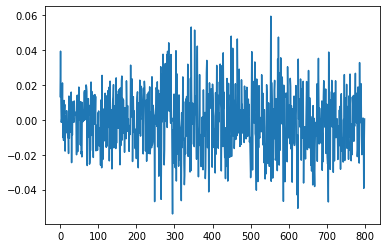

In [35]:
import matplotlib.pyplot as plt

plt.plot(X_train_svd_transformer.V_[1, :])
plt.show()

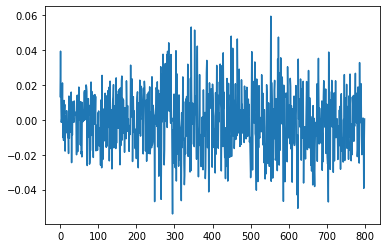

In [36]:
plt.plot(document_hat)
plt.show()

In [37]:
# train SVD
X_train_svd = X_train_svd_transformer.V_

In [38]:
X_test_tfidf

<1672x2001 sparse matrix of type '<class 'numpy.float64'>'
	with 24657 stored elements in Compressed Sparse Row format>

In [39]:
print(f'Sigma inverse reshaped: {sigma_inverse.reshape(-1,1).shape}')
print(f'U transpose: {U_transpose.shape}')
print(f'X_test Tfidf transpose: {X_test_tfidf.T.shape}')
# In R:
# test.svd.raw <- t(sigma.inverse * u.transpose %*% t(test.tokens.tfidf))
# (1671, 300) =  T of (300, ) * (300, 29241) %*% (29241, 1671) # R dims
# (1672, 800) =  T of (800, ) * (800, 2001)  %*%  (2001, 1672) # Python dims

Sigma inverse reshaped: (800, 1)
U transpose: (800, 2001)
X_test Tfidf transpose: (2001, 1672)


In [40]:
UT_TestTfidfT = (U_transpose @ X_test_tfidf.T)
UT_TestTfidfT.shape

(800, 1672)

In [41]:
X_test_svd = (sigma_inverse.reshape(-1,1) * UT_TestTfidfT).T

In [42]:
X_test_svd.shape

(1672, 800)

## Cosine Similarities

In [43]:
import scipy.sparse as sp
from scipy.sparse import csr_matrix
from sklearn.metrics.pairwise import cosine_similarity

__Training Set__

In [44]:
# all similarities
train_similarities = cosine_similarity(X_train_svd)

# spam similarities
train_df = pd.DataFrame({'sms':X_train, 'target':y_train}) 
train_spam_ix = train_df.loc[train_df['target']=='spam'].index

# mean spam sims
train_mean_spam_sims = []
for ix in range(train_similarities.shape[0]):
    mean_spam_sim = np.mean(train_similarities[ix, train_spam_ix])
    train_mean_spam_sims.append(mean_spam_sim)

# stack onto svd
X_train_processed = sp.hstack((csr_matrix(train_mean_spam_sims).T, 
                               X_train_svd))

__Test Set__

In [45]:
# add train spam SVD to test SVD and calculate all similarities
# we don't know which target are spam in the test set, of course!
test_similarities = cosine_similarity(sp.vstack((X_test_svd, 
                                                 X_train_svd[train_spam_ix])))

# get spam cols for spam similarities
spam_cols = range(X_test_svd.shape[0], test_similarities.shape[0])

# mean spam sims
test_mean_spam_sims = []
for ix in range(X_test_svd.shape[0]):
    mean_spam_sim = np.mean(test_similarities[ix, spam_cols])
    test_mean_spam_sims.append(mean_spam_sim)

# stack onto svd
X_test_processed = sp.hstack((csr_matrix(test_mean_spam_sims).T, 
                             X_test_svd))

## Persist


In [46]:
def persist(X, filename):
    proc_dir = os.path.join("data", "2_processed")
    filename = ''.join([filename, '.npz'])
    sp.save_npz(os.path.join(proc_dir, filename), X)

In [47]:
persist(X_test_processed, 'X_test_processed')

In [48]:
m, s = divmod(time.time() - start_, 60)
print(f'Elapsed: {m:0.0f} m {s:0.0f} s')

Elapsed: 0 m 41 s


---